In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Importing Packages and Defining Helper Functions

In [5]:
# Importing Packages

import os

import timeit

import iris
import iris.quickplot as qplt
from iris.analysis.cartography import unrotate_pole
from iris.coords import AuxCoord
import iris.coord_categorisation
from iris.util import equalise_attributes
from iris.util import unify_time_units

import numpy as np
from numpy import meshgrid

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", figsize=(10,10))

os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid

from scipy import stats
from scipy.optimize import minimize

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH

import jax.numpy as jnp
from jax import random, vmap, jit
import jax.scipy.stats.gamma as jgamma

# Importing Project Modules:

from src.netcdf_functions import pcolormesh_basemapplot



#from statsmodels.tsa.seasonal import STL

/data/conda/bc/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/data/conda/bc/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


<IPython.core.display.Javascript object>

In [1]:
import src.netcdf_functions

In [2]:
from src.netcdf_functions import pcolormesh_basemapplot

In [26]:
from src.test import pcolormesh_basemapplot

In [4]:
# Defining Helper Functions

def pcolormesh_basemapplot(cube,basemap,vmin,vmax,cmap=None):

    longitudes = cube.coord('longitude').points
    latitudes = cube.coord('latitude').points

    current_dir = os.getcwd()
    os.chdir(os.path.expanduser("~"))
    os.chdir('/data/climatedata')
    basemap.readshapefile('antarctica_shapefile', 'antarctica_shapefile',linewidth=0.1,antialiased=False,color='k')
    os.chdir(current_dir)
    
    return(basemap.pcolormesh(longitudes,latitudes,cube.data,vmin=vmin,vmax=vmax, latlon=True, cmap=cmap, shading = 'nearest',alpha=1))

def add_2d_latlon_aux_coords(cube):
    rotated_grid_latitude = cube.coord('grid_latitude').points
    rotated_grid_longitude = cube.coord('grid_longitude').points
    lons,lats = meshgrid(rotated_grid_longitude, rotated_grid_latitude)
    cs = cube.coord_system()
    lons,lats = unrotate_pole(lons,lats, cs.grid_north_pole_longitude, cs.grid_north_pole_latitude)
    #lons,lats = rotate_pole(lons,lats, cs.grid_north_pole_longitude, cs.grid_north_pole_latitude)
    
    grid_lat_dim = cube.coord_dims('grid_latitude')[0]
    grid_lon_dim = cube.coord_dims('grid_longitude')[0]
    
    cube.add_aux_coord(AuxCoord(points=lats, standard_name='latitude', units='degrees'),(grid_lat_dim,grid_lon_dim))
    cube.add_aux_coord(AuxCoord(points=lons, standard_name='longitude', units='degrees'),(grid_lat_dim,grid_lon_dim))
    
def aggregate_to_daily(cube):
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_day_of_year(cube, 'time', name='day_of_year')
    return cube.aggregated_by(['year','day_of_year'],iris.analysis.MEAN)

def stl_decomposition(timeseries):
    data = timeseries[:]
    ds = pd.Series(data, index=pd.date_range('1-1-1979', periods=len(data), freq='M'), name = 'Melt')
    stl = STL(ds, seasonal=13)
    #stl = STL(ds, seasonal=13,robust=True)
    res = stl.fit()
    
    return ([res.trend,res.seasonal,res.resid]) 

def concatenate_cubes(cubelist):
    equalise_attributes(cubelist)
    unify_time_units(cubelist)
    return cubelist.concatenate_cube()

<IPython.core.display.Javascript object>

# Loading and Examining Data

## Pre-processing Raw Data (Aggregating and Saving - Does not need to be done every time the notebook is loaded)

In [ ]:
#Loading 6hourly snowfall data and aggregating to daily as well as adding lat,lon coordinates

years = np.arange(1981,2019,1)
cubes = []
grid_cell = 50,50

for year in years:
    print(year)
    url = f"http://192.171.173.134/thredds/fileServer/dsnefiles/Jez/MetUM_Data/CORDEX_044_6Hourly/Antarctic_CORDEX_MetUM_0p44deg_6_hourly_mean_prsn_{year}.nc#mode=bytes"
    metum_cube = iris.load(url)[0]
    metum_cube = aggregate_to_daily(metum_cube)  # Note after aggregating this cube has shape 365/6,98,126
    add_2d_latlon_aux_coords(metum_cube)
    cubes.append(metum_cube)

metum_cube = concatenate_cubes(iris.cube.CubeList(cubes))
data_directory = '/data/climatedata/'
iris.save(metum_cube,f'{data_directory}metum_cube_lres.nc')

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


## Loading Data for use in Notebook

In [3]:
data_directory = '/data/climatedata/'
metum_cube = iris.load(f'{data_directory}metum_cube_lres.nc')[0]

In [4]:
metum_cube

Snowfall Flux (kg m-2 s-1),time,grid_latitude,grid_longitude
Shape,13879,98,126
Dimension coordinates,,,
time,x,-,-
grid_latitude,-,x,-
grid_longitude,-,-,x
Auxiliary coordinates,,,
day_of_year,x,-,-
forecast_period,x,-,-
forecast_reference_time,x,-,-
year,x,-,-


In [5]:
# Plotting the Average Daily Snowfall by Grid Cell

cube = metum_cube.collapsed('time',iris.analysis.MEAN)

antarctica_map = Basemap(width=6000000,height=5000000,projection='laea',lat_ts=-55,lat_0=-90,lon_0=0,resolution='l')
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
vmin=0
vmax=0.00005
cube.data[60,:]=1
cube.data[60,15]=0
pcolormesh_basemapplot(cube,antarctica_map,vmin,vmax)

/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_reference_time'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


NameError: name 'np' is not defined

<Figure size 800x800 with 0 Axes>

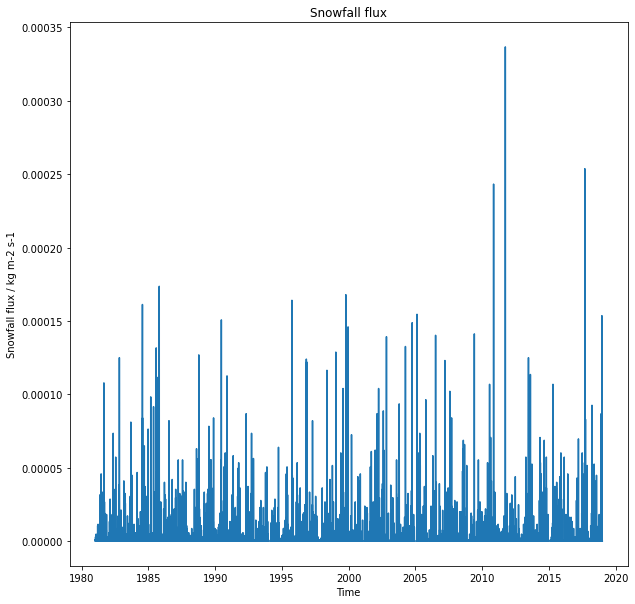

In [ ]:
# Plotting the daily timeseries of snowfall for a particular grid cell [50,50]

qplt.plot(metum_cube[:,50,50])

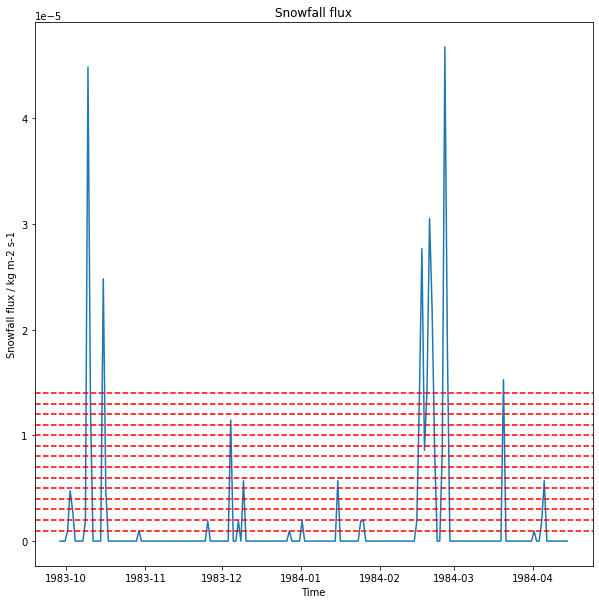

In [ ]:
# Zoomed in plot of daily snowfall showing the discreet nature of small values.

qplt.plot(metum_cube[1000:1200,50,50])
for y in np.arange(0.1*10**-5,1.5*10**-5,0.1*10**-5):
    plt.axhline(y=y, color='r', linestyle='--')

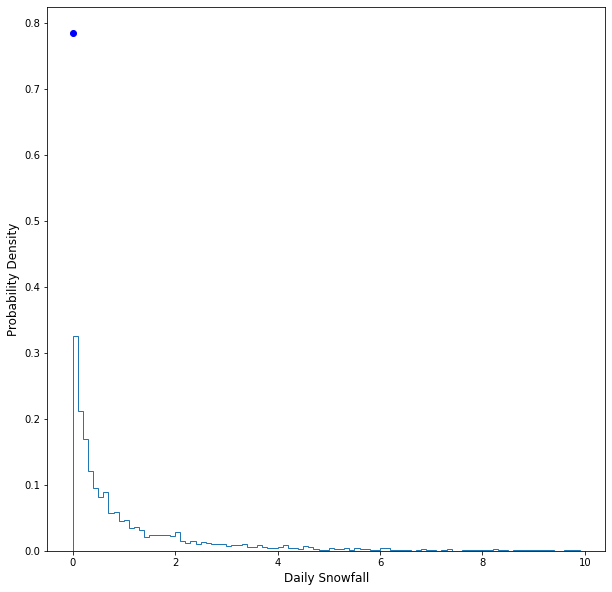

In [ ]:
# Plotting the Probability Distribution as a Histogram

data = metum_cube[:,50,50].data *10**5
bins = np.arange(0,10,0.1)
bin_width = bins[1]-bins[0]
weight_value = p/bin_width/len(data[data!=0])
weights = np.full(len(data[data!=0]),weight_value)

plt.hist(data[data!=0], bins=bins,histtype='step', stacked=True,fill=False,weights=weights)
plt.plot(0,1-len(data[data!=0])/len(data),'bo')
plt.xlabel('Daily Snowfall', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.show()

# Estimating PDF parameter values

From previous literature (Lima, 2021) it seems reasonable to assume a Bernoulli-Gamma distribution for daily snowfall. This has the form:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p)\cdot G(y|\alpha,\beta) = \ p \cdot \dfrac{\beta^\alpha y^{\alpha-1}e^{-\beta y}}{\Gamma(\alpha)} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

The Bernoulli part gives the probability of rainfall (p) or no rainfall (1-p) on a given day at the site \(j\) for month \(k\) and the Gamma part gives the probability of an intensity of rainfall ($y_{jk}$) on that day given rainfall occurs. The gamma distribution has shape parameter $\alpha$ and scale parameter $\beta$. Note: it makes sense to include a Bernoulli term because of the discontinuity expected for the probability of no rainfall. The shape/scale parameters $\alpha$ and $\beta$ are estimated at every rainfall gauge and for each month of the year. 

Bayesian inference is used to estimate the parameters $p,\alpha,\beta$ for every rainfall gauge and month. 

\begin{equation}
    P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot \dfrac{P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} \propto P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

\begin{equation}
    P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}}) =
    (\prod_{jk} B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})) \cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

## Test: Estimating Parameter Values for Single Site

In [240]:
# Test Site 50,50 

data = metum_cube[:,50,50].data * 10**5 # Note I found that for some reason the fitting procedure struggles with very small values of rainfall, so I multiply by 10^5

### Maximum Likelihood Estimation (Assuming no correlation between parameters)

For a given site: 


$Likelihood(\boldsymbol{Y}|p,\alpha,\beta)=L(\boldsymbol{Y}|p,\alpha,\beta)=\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)$

$Log(L(\boldsymbol{Y}|p,\alpha,\beta))= LL(\boldsymbol{Y}|p,\alpha,\beta) =Log(\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta))=\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$

MLE therefore involves minimising: $-\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$ where $y_i$ are our daily snowfall values.

In [8]:
# Defining the function to minimise:

def negloglikelihoodsum(params):
    p,a,scale = params[0],params[1],params[2]
    
    BGs = []
    
    for yi in data:
        if yi == 0:
            BG = 1-p
        else:
            BG = p*stats.gamma.pdf(yi, a=a,loc=0, scale=scale) 
        BGs.append(BG)
        
    return(-np.sum(np.log(BGs)))

In [ ]:
guess = np.array([0.5,0.1,1.0]) # Parameter Guesses
bounds = [(0.001,1),(0.00001,10),(0.00001,10)] # Parameter Bounds
results = minimize(negloglikelihoodsum,guess,method='Nelder-Mead',options={'disp':True},bounds=bounds) # Minimising Function
print(results['x'])

Optimization terminated successfully.
         Current function value: 10905.784839
         Iterations: 92
         Function evaluations: 165
[0.21579261 0.72923989 1.78159752]


In [ ]:
negloglikelihoodsum(results['x'])

10905.784838841713

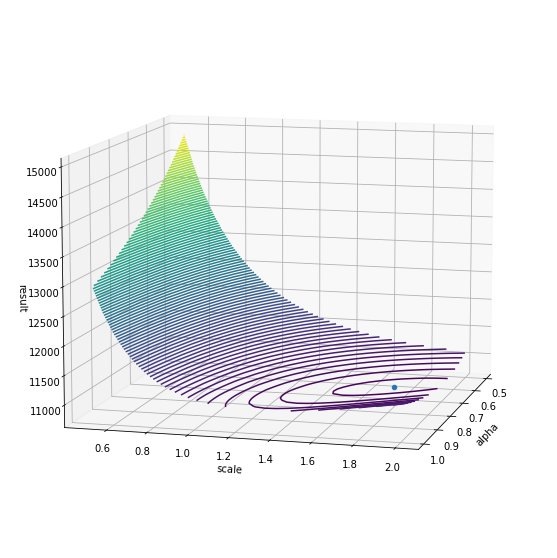

In [ ]:
# Plotting the Negative LogLikelihood Space for Parameters Alpha and Beta with fixed P

n=30
p = results['x'][0]
alphas = np.linspace(0.5, 1, n)
scales = np.linspace(0.5, 2, n)

alphas,scales = np.meshgrid(alphas, scales)
values = np.zeros((n,n))

for i in np.arange(0,n,1):
    for j in np.arange(0,n,1):
        values[i,j] = negloglikelihoodsum([p,alphas[i,j],scales[i,j]])
        
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(alphas, scales, values, 100)#, cmap='binary')

ax.set_xlabel('alpha')
ax.set_ylabel('scale')
ax.set_zlabel('result')

ax.scatter(results['x'][1],results['x'][2],negloglikelihoodsum(results['x']))

ax.view_init(10, 15)


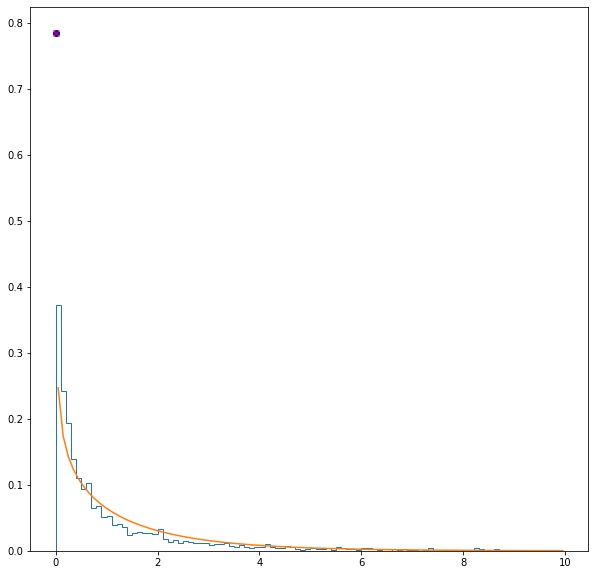

In [ ]:
bins = np.arange(0,10,0.1)
bin_centers = bins+bins[1]/2

p,a,scale = results['x']

estimates = []

for bin_center in bin_centers:
    result = p*stats.gamma.pdf(bin_center, a=a,loc=0, scale=scale)
    estimates.append(result)

bin_width = bins[1]-bins[0]
weight_value = p/bin_width/len(data[data!=0])
weights = np.full(len(data[data!=0]),weight_value)
    
plt.hist(data[data!=0], bins=bins,histtype='step', stacked=True,fill=False,weights=weights)
plt.plot(bin_centers,np.array(estimates))

plt.plot(0,1-p,'bo')
plt.plot(0,1-len(data[data!=0])/len(data),'rx')

plt.show()

### Bayesian Inference

We are treating the parameters $[p,\alpha,\beta]$ as stochastic variables here with probability distributions to estimate (the posterior distribution). In addition to simply estimating the parameters that maximise our likelihood this also allows us to estimate a credible interval and plot the uncertainty on our modelled PDF of snowfall.

#### Example of Non-scaled Posterior Sampling

In [9]:
# Priors
gamma_prior = stats.gamma(a=0.001,loc=0, scale=1000)
p=0.18

def priors(params):
    prior = gamma_prior.pdf(params[1])*gamma_prior.pdf(params[2])
    return(prior)

# Log-Likelihood
def log_likelihood(params): 
    p,a,scale = params[0],params[1],params[2]
    
    BGs = []
    
    for yi in data:
        if yi == 0:
            BG = 1-p
        else:
            BG = p*stats.gamma.pdf(yi, a=a,loc=0, scale=scale) 
        BGs.append(BG)
    
    return(np.log(BGs))  

# Log-Posterior
def log_posterior(params):
    log_post = np.sum(log_likelihood(params))+np.log(priors(params))
    return(log_post)

In [ ]:
# Sampling the parameter space
n=30
alphas = np.linspace(0.5, 1, n)
scales = np.linspace(0.5, 2, n)
alphas,scales = np.meshgrid(alphas, scales)

# Calculating the log-posterior for each set of parameters
results = np.zeros((n,n))
for i in np.arange(0,n,1):
    for j in np.arange(0,n,1):
        results[i,j] = log_posterior([0.18,alphas[i,j],scales[i,j]])

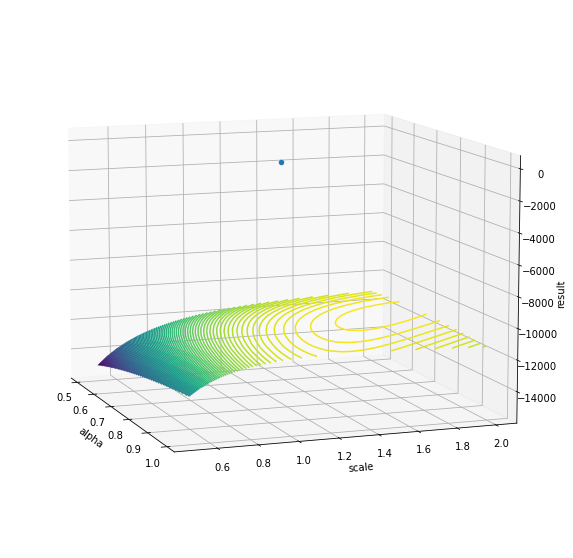

In [ ]:
# Plotting unscaled log-posterior
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(alphas, scales, results, 100)#, cmap='binary')

ax.set_xlabel('alpha')
ax.set_ylabel('scale')
ax.set_zlabel('result')

ax.scatter(0.79,1.18,-253.8)

ax.view_init(10, -20)

#### Example of Doing MCMC with Numpyro

Note Numpyro is a machine learning wrapper for Numpy and many of the routines require you to use jax arrays etc. 

In [241]:
data.data.shape

(13879,)

In [243]:
# Converting test dataset to jax dataset
jdata = jnp.array(data.data[:365]) 

In [244]:
# Defining a Likelihood function that uses jax arrays and pdfs etc
def likelihood(data,priors):
    p,a,scale = priors[0],priors[1],priors[2]
    BGs = []
    for yi in data:
        if yi == 0:
            BG = 1-p
        else:
            BG = p*jgamma.pdf(yi, a=a,loc=0, scale=scale) 
        BGs.append(BG)
    
    BGs = jnp.array(BGs)
    
    return(BGs)

# Defining a Log-Posterior function that uses jax arrays and pdfs etc

def log_posterior(data,priors):
    
    p,a,scale = priors[0],priors[1],priors[2]

    log_post = jnp.sum(jnp.log(likelihood(data,[p,a,scale])))+jnp.log(p)+jnp.log(a)+jnp.log(scale)
    
    return(log_post)


In [252]:
#Numpyro syntax for defining MCMC problem:

def model(data): 
    
    #Define Priors (All Non-Informative)
    p = numpyro.sample("p", dist.Uniform(0, 1.0))
    a = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    scale = numpyro.sample("scale", dist.Gamma(0.001, 0.001))
    
    #Defining Log-Posterior result given data and parameters
    lp = numpyro.factor("y", log_posterior(data,[p,a,scale]))


In [246]:
rng_key = random.PRNGKey(0)

In [247]:
np.random.randint(1000, size=10)

array([157, 497, 875, 864, 476, 853, 777, 366, 470, 223])

In [218]:
values = []
for i in np.arange(0,1000,1):
    values.append(numpyro.sample("a", dist.Gamma(0.001, 0.001),rng_key=random.PRNGKey(i)))

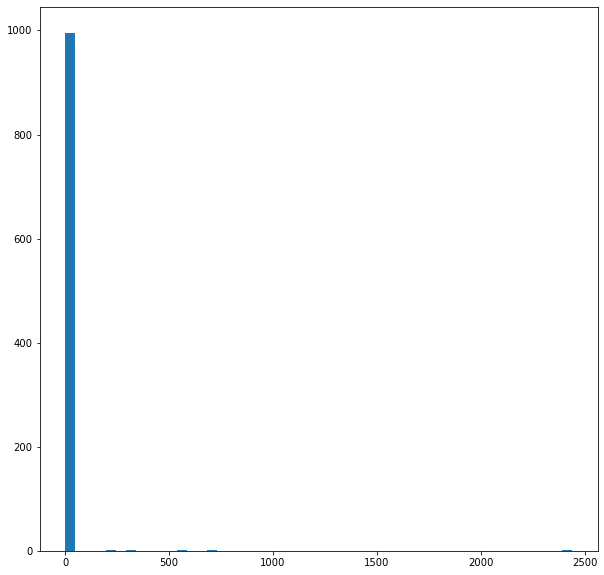

In [221]:
plt.hist(np.array(values),bins=50)
plt.show()

In [182]:
numpyro.sample("a", dist.Gamma(0.001, 0.001),rng_key=rng_key)

DeviceArray(1.1754943e-35, dtype=float32)

In [225]:
random.PRNGKey(10)

DeviceArray([ 0, 10], dtype=uint32)

In [236]:
rng_key = random.PRNGKey(0)
#random.split(rng_key)
rng_key, rng_key_ = random.split(rng_key)

In [237]:
rng_key_

array([2718843009, 1272950319], dtype=uint32)

In [251]:
#Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
#kernel = HMC(model)
#kernel = BarkerMH(model)
num_samples = 1000
num_warmup= 500
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)#,num_chains=2)
mcmc.run(
    rng_key_, jdata)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

TypeError: Expected a callable value, got -611.1370239257812

In [29]:
# Trying to plot the Prob(y|estimated parameters) (Likelihood)

ps = jnp.expand_dims(samples_1["p"], -1)
alphas = jnp.expand_dims(samples_1["a"], -1)
scales = jnp.expand_dims(samples_1["scale"], -1)

#ys = np.arange(0,5,0.1)
bins = np.arange(0,10,0.5)
bin_centers = bins+bins[1]/2

likelihood_values = []

for i in np.arange(0,len(ps),1):
    p = ps[i]
    a = alphas[i]
    scale = scales[i]
    
    #LogLikelihood = LL(ys,[p,a,scale])
    l_value = likelihood(bin_centers,[p,a,scale])
    
    likelihood_values.append(l_value)
    

In [30]:
mean_l = jnp.mean(jnp.array(likelihood_values), axis=0)
hpdi_l = hpdi(jnp.array(likelihood_values), 0.9)
lower_l = hpdi_l[0][:,0]
upper_l = hpdi_l[1][:,0]

In [31]:
zero_likelihood_values = []

for i in np.arange(0,len(ps),1):
    p = ps[i]
    a = alphas[i]
    scale = scales[i]
    
    #LogLikelihood = LL(ys,[p,a,scale])
    l_value = likelihood([0],[p,a,scale])
    
    zero_likelihood_values.append(l_value)

In [32]:
zero_mean_l = jnp.mean(jnp.array(zero_likelihood_values), axis=0)
zero_hpdi_l = hpdi(jnp.array(zero_likelihood_values), 0.9)
zero_lower_l = zero_hpdi_l[0][:,0]
zero_upper_l = zero_hpdi_l[1][:,0]

In [33]:
zero_lower_error = zero_mean_l-zero_lower_l
zero_upper_error = zero_upper_l - zero_mean_l

In [34]:
error = np.array([zero_lower_error[0],zero_upper_error[0]])

In [19]:
zero_lower_error[0]

DeviceArray([0.05234897], dtype=float32)

In [20]:
error.shape

(2, 1)

In [21]:
zero_lower_l

array([0.8028735], dtype=float32)

In [ ]:
p_data = len(data[data!=0])/len(data)

In [ ]:
p_data

0.1885245901639344

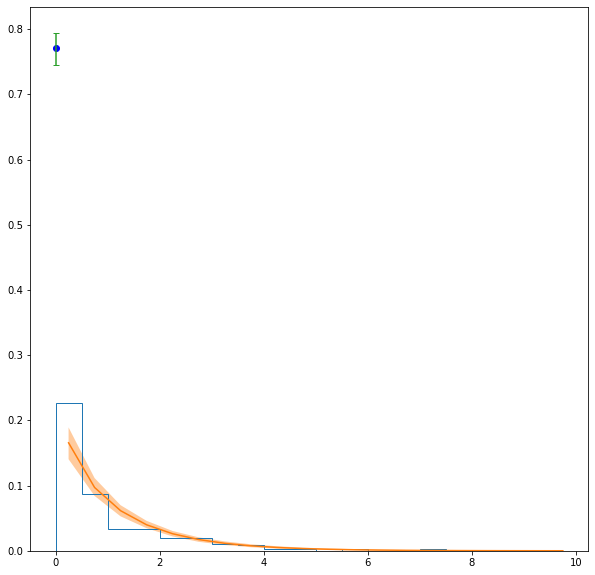

In [35]:
data_used = data.data[:730]
bin_width = bins[1]-bins[0]
p_data_used = len(data_used[data_used!=0])/len(data_used)
weight_value = p_data_used/bin_width/len(data_used[data_used!=0])
weights = np.full(len(data_used[data_used!=0]),weight_value)
    
plt.hist(data_used[data_used!=0], bins=bins,histtype='step', stacked=True,fill=False,weights=weights)

plt.plot(bin_centers,mean_l)
plt.fill_between(bin_centers,y1=lower_l, y2=upper_l,alpha=0.4)

plt.plot(0,1-ps.mean(),'bo')
#plt.plot(0,1-p_data_used,'rx')
plt.errorbar(0,zero_mean_l, yerr=error,capsize=3)

plt.show()

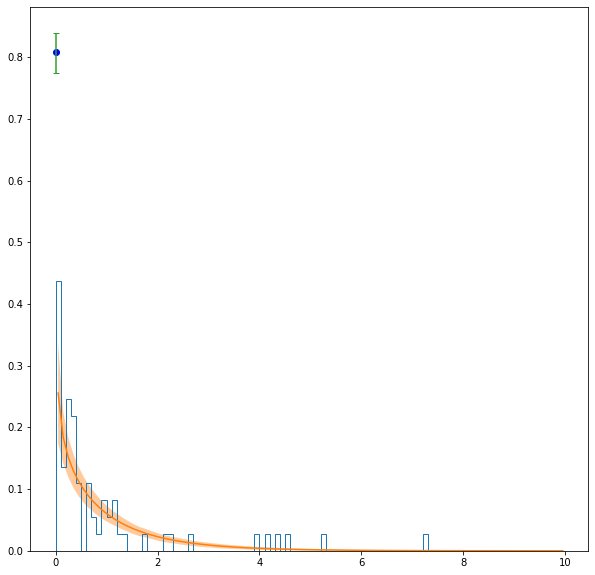

In [ ]:
bin_width = bins[1]-bins[0]
p_data = len(data[data!=0])/len(data)
weight_value = p_data/bin_width/len(data[data!=0])
weights = np.full(len(data[data!=0]),weight_value)
    
plt.hist(data[data!=0], bins=bins,histtype='step', stacked=True,fill=False,weights=weights)

plt.plot(bin_centers,mean_l)
plt.fill_between(bin_centers,y1=lower_l, y2=upper_l,alpha=0.4)

plt.plot(0,1-ps.mean(),'bo')
#plt.plot(0,1-p_data,'rx')
plt.errorbar(0,zero_mean_l, yerr=error,capsize=3)

plt.show()

#### Example of Doing MCMC with Dependencies between Parameters Numpyro

In [5]:
iris.coord_categorisation.add_month_number(metum_cube, metum_cube.coord('time'), name='month_number')

In [6]:
metum_cube.coord('month_number').shape

(13879,)

In [63]:
data = metum_cube[:,50,50].data * 10**5
data_seperate_months = []

for i in np.arange(1,13,1):
    month_data = []
    for j in np.arange(0,len(data),1):
        if metum_cube.coord('month_number').points[j]==i:
            month_data.append(data[j])
    
    data_seperate_months.append(np.array(month_data))


In [36]:
jdata = jnp.array(data.data[:730]) 

In [68]:
np.random.choice([1,2,3,4,5,6], 3)

array([4, 2, 2])

In [70]:
np.random.choice([1,2,3,4,5,6], 3, replace=False, p=None)

array([3, 6, 2])

In [118]:
jdata_seperate_months = []
for month_data in data_seperate_months:
    data_sample = np.random.choice(month_data, 100, replace=False, p=None)
    jmonth_data = jnp.array(data_sample)
    jdata_seperate_months.append(jmonth_data)

In [37]:
import jax.scipy.stats.norm as jnorm

In [73]:
np.log([10,20])

array([2.30258509, 2.99573227])

In [122]:
# Defining a Likelihood function that uses jax arrays and pdfs etc
def likelihood(data_seperate_months,priors):
    ps,alphas,scales = priors[0],priors[1],priors[2]
    BGs = []
    counter =0 
    for month_data in data_seperate_months:
        a = alphas[counter]
        scale = scales[counter]
        p = ps[counter]
        counter+=1
        for yi in month_data:
            if yi == 0:
                BG = 1-p
            else:
                BG = p*jgamma.pdf(yi, a=a,loc=0, scale=scale) 
            BGs.append(BG)
    
    BGs = jnp.array(BGs)
    
    return(BGs)

# Defining a Log-Posterior function that uses jax arrays and pdfs etc

def log_posterior(data_seperate_months,priors):
    
    ps,alphas,scales = priors[0],priors[1],priors[2]

    log_post = jnp.sum(jnp.log(likelihood(data_seperate_months,[ps,alphas,scales])))+jnp.log(jnp.array(ps))+jnp.log(jnp.array(alphas))+jnp.log(jnp.array(scales))
    
    return(log_post)

In [ ]:
def LP(data,priors):
    
    p,a,scale = priors[0],priors[1],priors[2]
    print(a)
    #scale = jnp.reciprocal(beta)
    LPOST = jnp.sum(LL(data,[p,a,scale]))+jnp.log(p)+jnp.log(np.array(a))+jnp.log(np.array(scale))
    
    return(LPOST)

In [101]:
np.array([1,2,3]).dtype

dtype('int64')

In [100]:
data_seperate_months[0].dtype

dtype('float64')

In [102]:
for a in data_seperate_months[0]:
    print(a)

0.095367431640625
0.0
0.0
0.0
0.0
0.095367431640625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.286102294921875
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.476837158203125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.57220458984375
0.0
0.0
0.57220458984375
0.286102294921875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.33514404296875
0.0
0.286102294921875
0.0
0.0
0.0
0.0
0.95367431640625
0.0
0.0
0.0
0.0
0.0
0.3814697265625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.095367431640625
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.57220458984375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.19073486328125
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.095367431640625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.286102294921875
0.0
0.0
0.0
0.0
0.476837158203125
0.1

In [103]:
for month_data in data_seperate_months:
    for data in month_data:
        print(data)

0.095367431640625
0.0
0.0
0.0
0.0
0.095367431640625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.286102294921875
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.476837158203125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.57220458984375
0.0
0.0
0.57220458984375
0.286102294921875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.33514404296875
0.0
0.286102294921875
0.0
0.0
0.0
0.0
0.95367431640625
0.0
0.0
0.0
0.0
0.0
0.3814697265625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.095367431640625
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.57220458984375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.19073486328125
0.19073486328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.095367431640625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.286102294921875
0.0
0.0
0.0
0.0
0.476837158203125
0.1

In [124]:
#Numpyro syntax for defining MCMC problem:
#Want a different parameter for each month

def model(data_seperate_months): 
    
    #p = numpyro.sample("p", dist.Uniform(0, 1.0))
    
    #Hyper-Params:
    a0 = numpyro.sample("a0", dist.Uniform(0, 10.0))
    a1 = numpyro.sample("a1", dist.Uniform(0, 10.0))
    var = numpyro.sample("betavar", dist.InverseGamma(0.001, 0.001))
    
    ps = []
    alphas = []
    scales = []
    
    counter = 0
    for jmonth_data in jdata_seperate_months:
        ps.append(numpyro.sample(f"p{counter}", dist.Uniform(0, 1.0)))
        alphas.append(numpyro.sample(f"alpha{counter}", dist.Gamma(0.001, 0.001)))
        scales.append(jnp.reciprocal(numpyro.sample(f"scale{counter}", dist.LogNormal(a0+a1*alphas[counter],var))))
        counter+=1
        
        
    # a1 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a2 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a3 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a4 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a5 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a6 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a7 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a8 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a9 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a10 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    # a11 = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    
    
#     #Define Priors (trying to predict p,a,var)
#     p = numpyro.sample("p", dist.Uniform(0, 1.0))
#     a = numpyro.sample("a", dist.Gamma(0.001, 0.001))
    
#     #a0 = 1
#     #a1 = 1
    
#     a0 = numpyro.sample("a0", dist.Uniform(0, 10.0))
#     a1 = numpyro.sample("a1", dist.Uniform(0, 10.0))
#     var = numpyro.sample("betavar", dist.InverseGamma(0.001, 0.001))
#     beta = numpyro.sample("beta", dist.LogNormal(a0+a1*a,var))
    
#     #dist.LogNormal(1/(a0+a1*a),var).log_prob
#     scale = jnp.reciprocal(beta)

    
    #scale = numpyro.sample("scale", dist.Gamma(0.001, 0.001))
    
    #Defining Log-Posterior result given data and parameters
    LPG = numpyro.factor("y", log_posterior(jdata_seperate_months,[ps,alphas,scales]))

In [112]:
# #Redefining with beta

# # Defining a new Log-Likelihood function that uses jax arrays and pdfs etc
# def LL(data,priors):
#     p,a,scale = priors[0],priors[1],priors[2]
    
#     #print(p.type())
#     #scale = jnp.reciprocal(beta)
#     BGs = []
#     for yi in data:
#         if yi == 0:
#             BG = 1-p
#         else:
#             BG = p*jgamma.pdf(yi, a=a,loc=0, scale=scale) 
#         BGs.append(BG)
    
#     BGs = jnp.array(BGs)
#     LBGs = jnp.log(BGs)
    
#     return(LBGs)

# # Defining a new Log-Posterior function that uses jax arrays and pdfs etc
# def LP(data,priors):
    
#     p,a,scale = priors[0],priors[1],priors[2]
#     print(a)
#     #scale = jnp.reciprocal(beta)
#     LPOST = jnp.sum(LL(data,[p,a,scale]))+jnp.log(p)+jnp.log(np.array(a))+jnp.log(np.array(scale))
    
#     return(LPOST)

In [125]:
#Numpyro syntax for running MCMC
starttime = timeit.default_timer()
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 1000
mcmc = MCMC(kernel, num_warmup=500, num_samples=num_samples)
mcmc.run(
    rng_key_, jdata_seperate_months)
mcmc.print_summary()
samples_1 = mcmc.get_samples()
print("Time Taken:", timeit.default_timer() - starttime)

sample: 100%|██████████| 1500/1500 [01:57<00:00, 12.81it/s, 15 steps of size 2.48e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0      0.14      0.14      0.10      0.00      0.35    987.72      1.00
        a1      0.26      0.21      0.22      0.00      0.56   1046.58      1.00
    alpha0      2.62      0.28      2.62      2.12      3.02    526.67      1.00
    alpha1      0.44      0.04      0.44      0.37      0.49   1025.59      1.00
   alpha10      0.77      0.06      0.77      0.68      0.88    955.75      1.00
   alpha11      0.41      0.04      0.41      0.35      0.48    943.41      1.00
    alpha2      0.77      0.06      0.77      0.67      0.87    886.96      1.00
    alpha3      0.95      0.07      0.95      0.83      1.06    882.22      1.00
    alpha4      1.06      0.07      1.05      0.94      1.17    879.66      1.00
    alpha5      1.02      0.07      1.02      0.91      1.13    629.85      1.00
    alpha6      0.71      0.04      0.71      0.63      0.78    806.92      1.00
    alpha7      0.65      0

In [150]:
alpha_means = []
scale_means = []
log_beta_means = []

for i in np.arange(0,12,1):
    alpha_means.append(jnp.expand_dims(samples_1[f"alpha{i}"], -1).mean())
    scale_means.append(jnp.expand_dims(samples_1[f"scale{i}"], -1).mean())
    #log_beta_means.append(-jnp.log(jnp.reciprocal(jnp.expand_dims(samples_1[f"scale{i}"], -1))).mean())

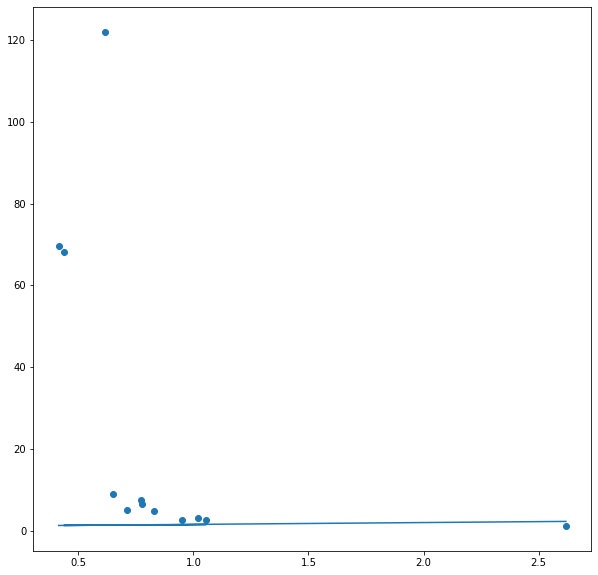

In [160]:
plt.scatter(alpha_means,np.exp(np.reciprocal(scale_means)))
plt.plot(alpha_means,np.exp(np.array(alpha_means)*0.26+0.14))

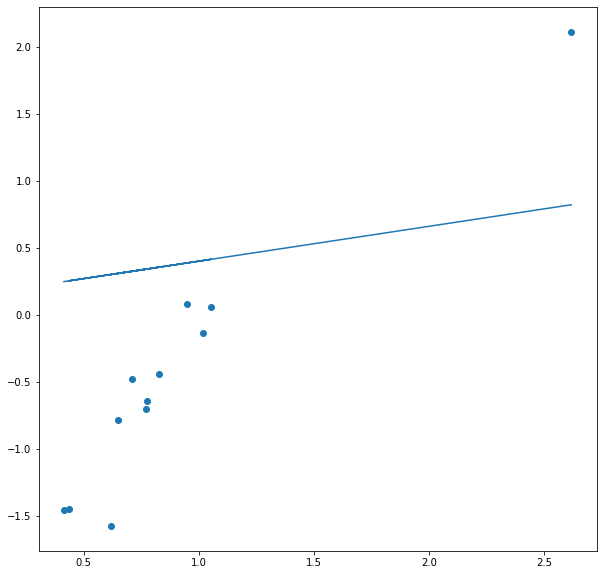

In [149]:
plt.scatter(alpha_means,log_beta_means)
plt.plot(alpha_means,np.array(alpha_means)*0.26+0.14)